SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #9: Ensembels of TS Forecasting Algorithms </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - compositions of time series forecasting Algorithms, Adaptive Composition, Apdative Selection, Aggregating Algorithm

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityWAPE, qualityRMSE, \
SimpleExponentialSmoothing, HoltExponentialSmoothing, AdditiveWintersExponentialSmoothing, TheilWageExponentialSmoothing
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# Simple Compositions
Online learning protocol for a time series composition:
* For $t=0, \dots, T,\dots$
 - 1) get forecast $\hat y_{t+1}^A$ of all base algorithms $A\in\mathfrak{A}$;
 - 2) composition $C$ builds own forecast value $\hat{y}_{t+1}^C\in\Gamma$;
 - 3) obtain outcome $y_{t+1}\in\Omega$;
 - 4) calculate loss $\lambda\left(y_{t+1},\hat{y}_{t+1}\right)$.

where $\Omega~-$ a set of all possible outcomes, $\Gamma~-$ a set of allowed predictions (yes, sometimes $\Gamma\not=\Omega$), $\lambda~-$ loss function. 

**Question:**
* Why composition of simple algorithm (=base algorithms) can outperform base algorithms?

   - Answer: composition leverages advantages of simple algrithms or/and smooths disadvantages od them

<br></br>
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/TSCompositionExample.PNG?raw=true'>

## Adaptive Selection

Here are $N$ base algorithms $A_1,\dots, A_N$,

* $\hat y_{t+d}^j$ --- forecast of $A_j$ for the moment $t+d$,

*    $e_{t}^j = y_t - \hat y_{t}^j$ --- error of $A_j$ at the moment $t$,

*    $\color{red}{\tilde e_{t}^j} = \delta\sum\limits_{l=1}^{t}(1-\delta)^{t-l} |e_{l}^j|~-$ exponentially weighted absolute error,

* $\delta~-$ smoothing parameter.

<br></br>   

Select the best base algorithm in the moment $t$:
$$\color{blue}{j_t^*} = \arg\min_{j=1,\dots,N} \color{red}{\tilde e_{t}^j}.$$

<br></br>   

Adaptive uses forecasts of the most best algorithms at the moment $t$ :
 $$
    \color{green}{\mathfrak{I}_t^*(\varepsilon)}= \left\{i| \tilde e_{t}^i \leq \tilde e_{t}^{\color{blue}{j_t^*}}+\varepsilon \right\}.
   $$

<br></br>

Forecast of the Adaptive Selection (composition):
$$\hat y_{t+d}^{AS} := \frac{1}{\left|\mathfrak{J}_t^*(\varepsilon)\right|} \sum_{i\in \color{green}{\mathfrak{I}_t^*(\varepsilon)} } \hat y_{t+d}^i.$$


**Question** 
* How many algorithms will be in $\color{green}{\mathfrak{I}_t^*(\varepsilon)}$ if $\varepsilon = 0$?

* Which parameters does the Adaptive Selection have?
   - Answer: $\delta, \varepsilon, loss function$

In [ ]:
# Loss functions
def MAE(x, predicted):
    return np.abs(x - predicted)

def MSE(x, predicted):
    return (x - predicted) ** 2

def exp_MAE(x, predicted):
    return np.exp(np.abs(x - predicted))

def exp_MSE(x, predicted):
    return np.exp((x - predicted) ** 2)

In [ ]:
def adaptive_selection(x, h, params, loss = MAE):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        delta <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - threshold for best indistinguished ba
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(N):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
        
    # internal params of composition
    delta = params['delta']
    eps = params['eps']
    
    if delta>1:
        w.warn('Delta can not be more than 1')
        #alpha = 1
        return FORECAST
    if delta<0:
        w.warn('Delta can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N)  # initialization of errors of base algorithms 
    j_best = 0
    
    y=np.NaN
        
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                'TODO: check this code'
                e1 = delta * loss(x[t], FORECAST_BA.transpose()[t])+(1-delta)*e1
                if np.isnan(e1.sum()):
                    e1=np.zeros(N)
                # select best algorithm at the moment t
                j_best = np.argmin(e1)#'TODO: find index of best base alg'
                # select best indistinctive
                idx_bestinsdistinctive =[]
                for i in range(N):
                    if abs(e1[i]-e1[j_best])<eps:
                        idx_bestinsdistinctive.append(i)# 'TODO: find indexes of best indistinctive algorithms'
                
                y = FORECAST_BA.transpose()[t + h,idx_bestinsdistinctive].mean()
                # else do nothing
#         else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST, FORECAST_BA

## Adaptive Combination

There is $N$ base algorithms $A_1,\dots, A_N$,

* $\hat y_{t+d}^j$ --- forecast of $A_j$ for the moment $t+d$,

*    $e_{t}^j = y_t - \hat y_{t}^j$ --- error of $A_j$ at the moment $t$,

*    $\color{red}{\tilde e_{t}^j} = \delta\sum\limits_{l=1}^{t}(1-\delta)^{t-l} |e_{l}^j|~-$ exponentially weighted absolute error,

* $\delta~-$ smoothing parameter.

<br></br>   

Adaptive Combination measures weight of each base algorithm based on it loss at the moment $t$ :
 $$ \color{red}{w_{t}^j} = \frac{(\tilde e_{t}^j)^{-1}}{\sum\limits_{s=1}^N (\tilde e_{t}^s)^{-1}}. $$

<br></br>

Forecast of the Adaptive Combination:
 $$\hat y_{t+d}^{A} = \sum_{j=1}^N \color{red}{w_{t}^j}\cdot \hat y_{t+d}^j $$


**Question** 
* Forecast of how many algorithms will be considered at the moment $t$?

* Which parameters does the Adaptive Combination have?
   - Answer:

In [ ]:
def adaptive_combination(x, h, params, loss = exp_MAE):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        delta <scalar in [0,1]> - smoothing parameter of error
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    
    # internal params of composition
    delta = params['delta']
    
    if delta>1:
        w.warn('Delta can not be more than 1')
        return FORECAST
    if delta<0:
        w.warn('Delta can not be less than 0')
        return FORECAST

    
    e1= np.array(np.ones(N))  # initialization of errors of base algorithms 
    weights = np.array(np.zeros(N))
    
    y=np.NaN
    e_predicted = np.NaN
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                if (e_predicted == "nan"):
                    e_predicted = loss(x[t], FORECAST_BA.transpose()[t])
                e_predicted = delta * loss(x[t], FORECAST_BA.transpose()[t]) + \
                    (1 - delta) * e_predicted # we may use any other algorithm to predict the lss
                
                level = e_predicted
                
                if np.isnan(e_predicted.sum()):
                    e_predicted=np.ones(N)
                inv_e = np.array([x**(-1) for x in e_predicted])
                
                # calculate weights
                weights = inv_e/inv_e.sum()
                
#               Calculate forecast of the composition
                y = FORECAST_BA.transpose()[t + h].dot(weights)
            
        FORECAST[t+h] = y
    return FORECAST, FORECAST_BA

## Example of Forecasts

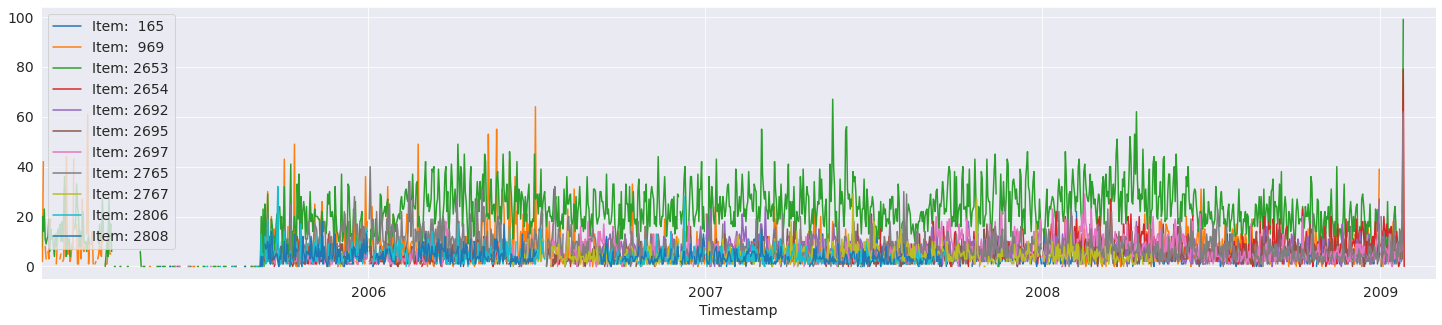

In [ ]:
# Read datae (time series)b
ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index
ts.plot()

In [ ]:
# Define forecast perameters
h =1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()
BA_FRC_TS = dict()

In [ ]:
# Base algorithms
base_algs = [{'base_alg':'SimpleExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'HoltExponentialSmoothing', 'base_alg_params':{'alpha':0.1,'beta':0.01, 'AdaptationPeriod':10}},
            # {'base_alg':'AdditiveWintersExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':1, 'seasonality_period':7}},
#            {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'gamma':0.01}},
            # {'base_alg':'TheilWageExponentialSmoothing', 'base_alg_params':{'alpha':0.3, 'beta':0.9,'delta':0.9, 'gamma':0.1, 'seasonality_period':7}}
]

for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

SimpleExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
HoltExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [ ]:
# run Adaptive Selection
#deltas = [0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999]
delta=0.1
eps = 1.0
for cntr in ts.columns:
    frc_ts[cntr], BA_FRC_TS[cntr] = adaptive_selection(ts[cntr],h, {'delta':delta, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS delta %.4f eps %.4f' % (delta, eps)] = frc_ts

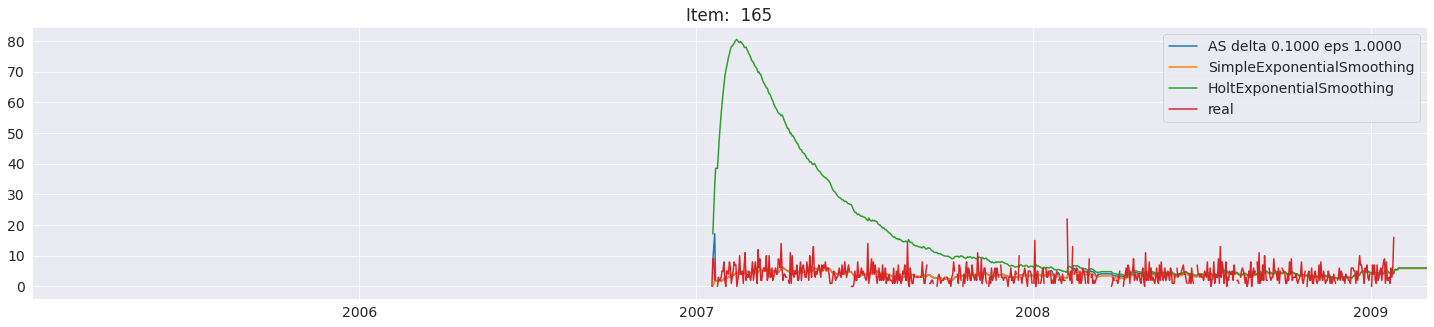

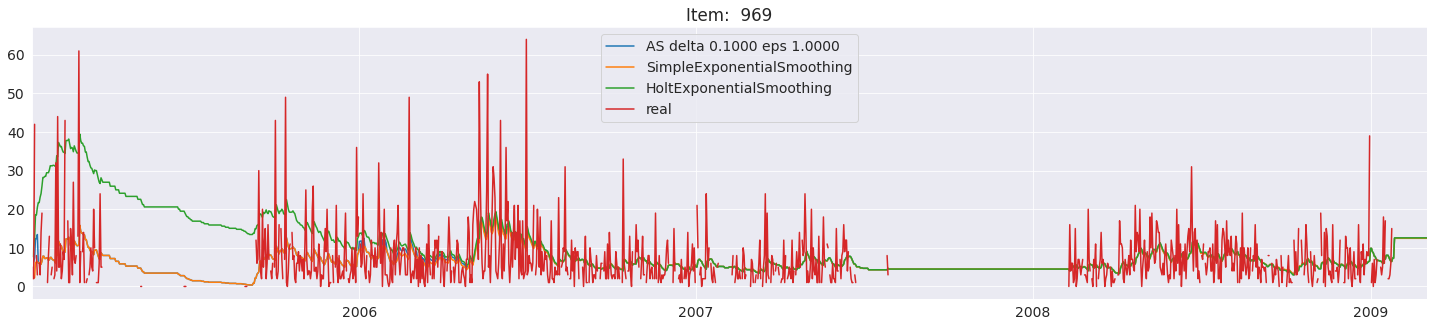

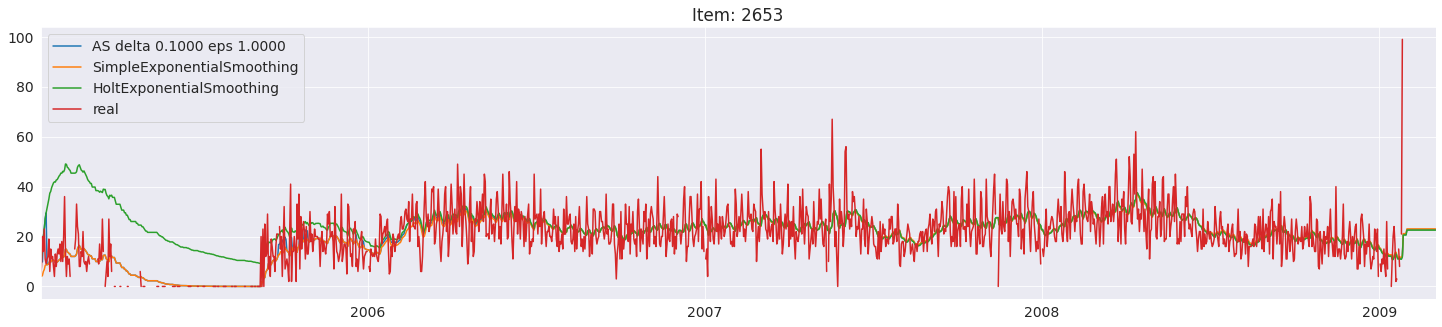

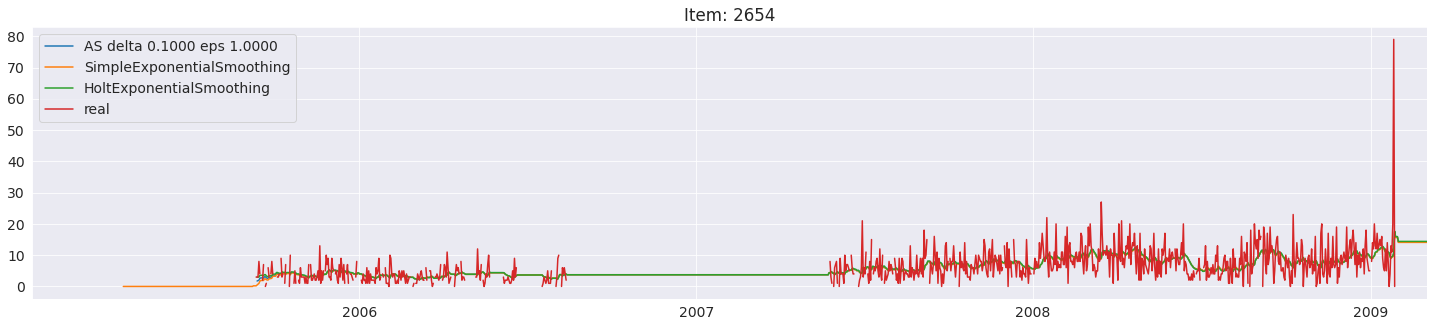

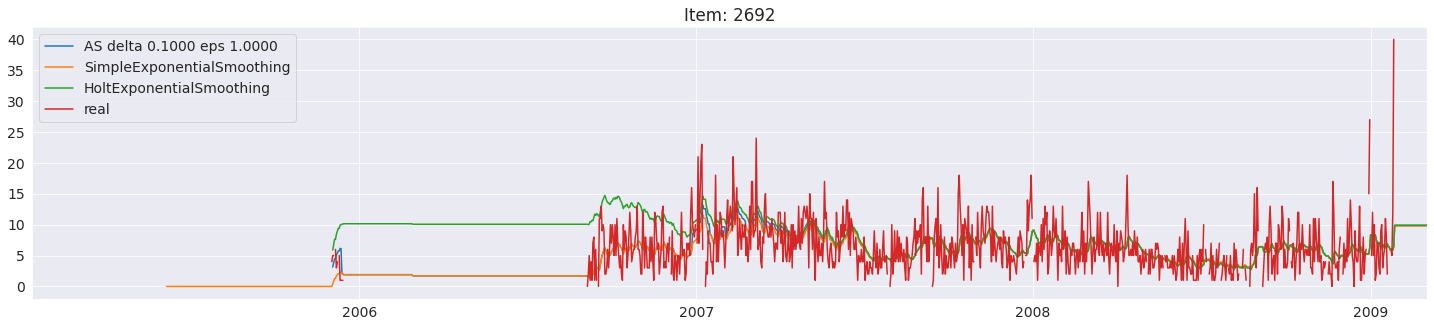

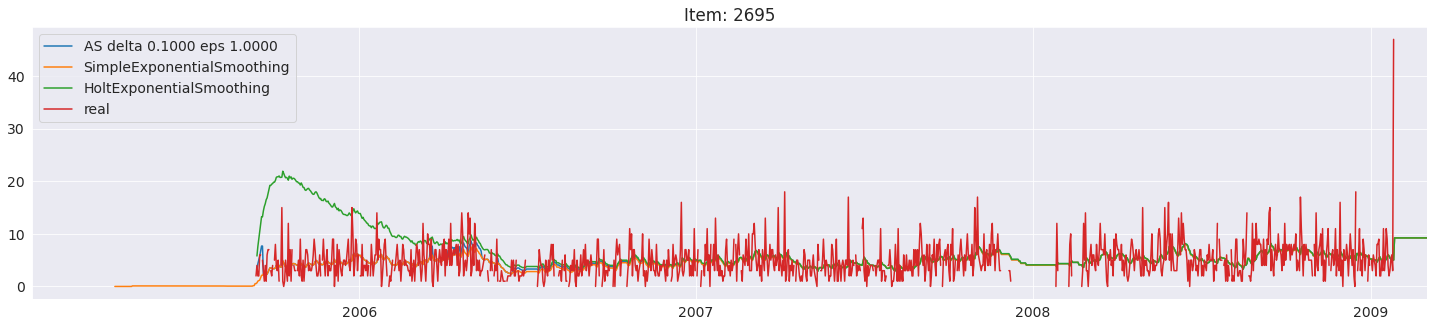

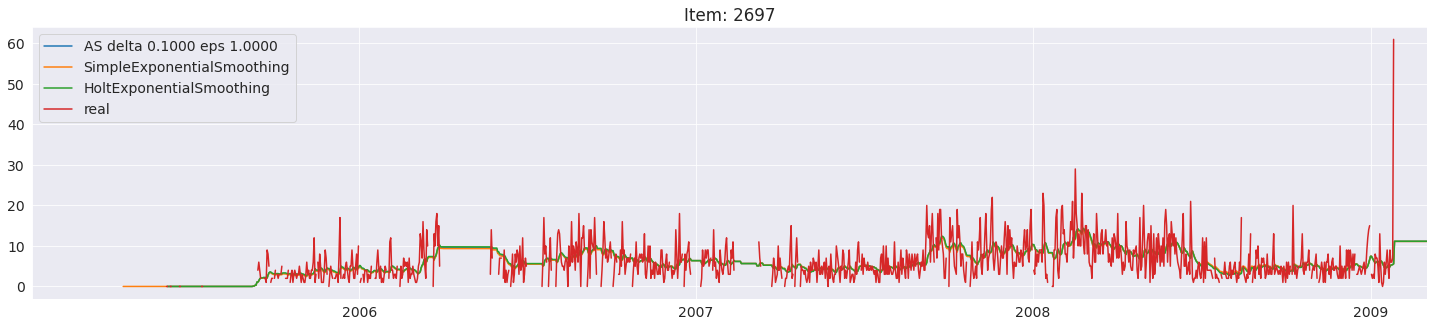

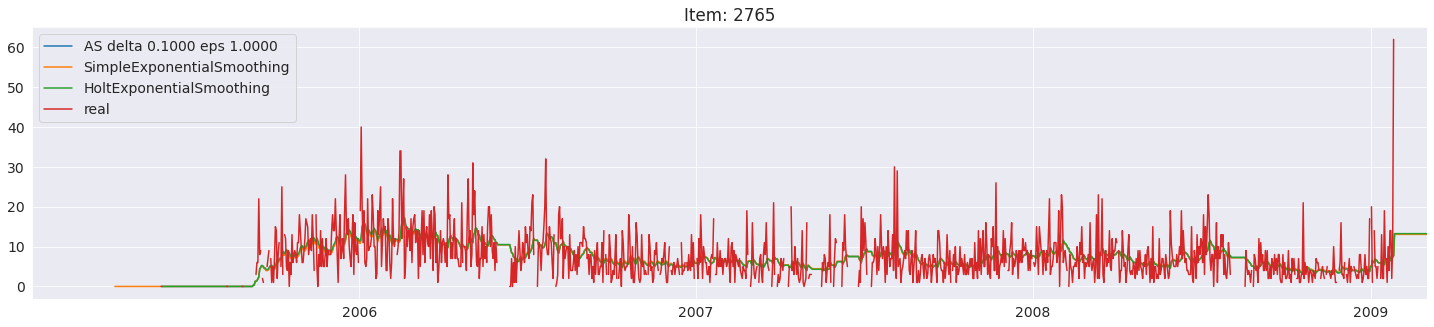

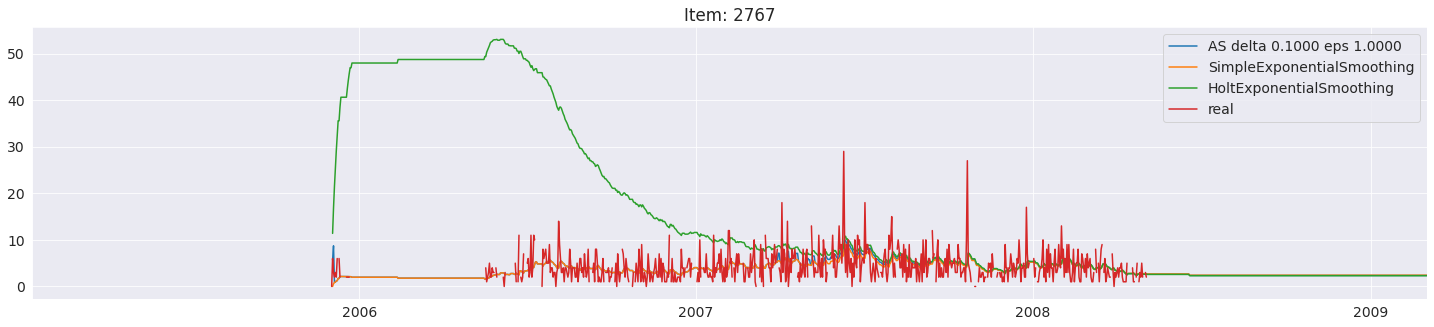

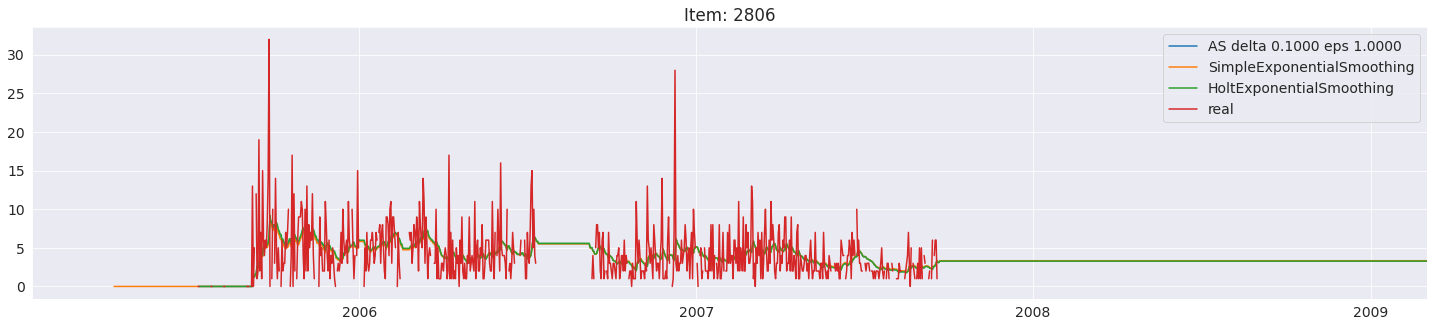

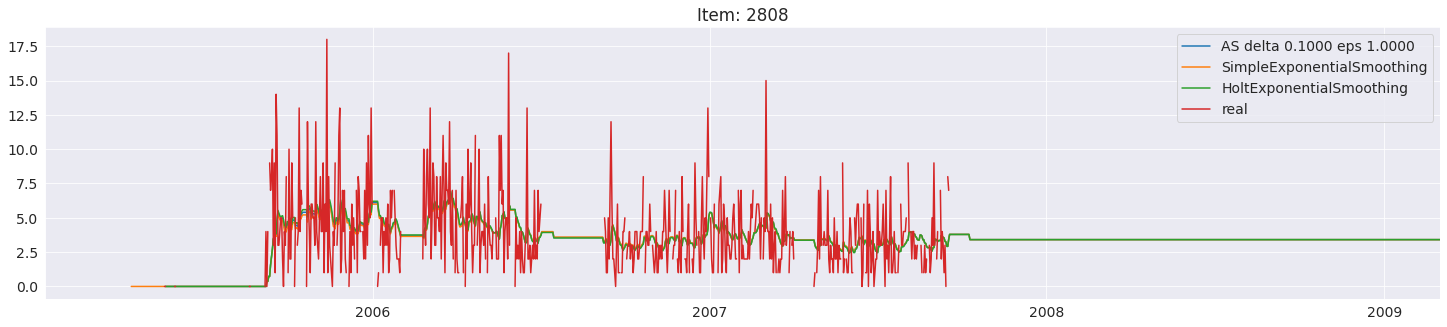

In [ ]:
# draw forecast of Adaptive Selection
alg_name = 'AS delta %.4f eps %.4f' % (delta, eps)
for col in ts.columns:
    forecast = FRC_TS[alg_name][[col]].copy(deep=True)
    forecast.rename(columns={col:alg_name}, inplace=True)
    for i in range(len(base_algs)):
      forecast[base_algs[i]['base_alg']] = BA_FRC_TS[col][i]
      # print(BA_FRC_TS[col][i])
      # pd.DataFrame(BA_FRC_TS[col][i]).plot(color='blue', label=base_algs[0]['base_alg'], alpha = 1)
  #  forecast[col].plot(color='red', label=alg_name, alpha = 1)
    forecast['real'] = ts[col]
    forecast.plot()
    plt.title(col)
    plt.legend()
    plt.show()

In [ ]:
# run (build forecast) Adaptive Combination
delta=0.01

for cntr in ts.columns:
    frc_ts[cntr], BA_FRC_TS[cntr]= adaptive_combination(ts[cntr],h, {'delta':delta, 'base_alg_params':base_algs})
FRC_TS['AC delta %.2f' % (delta)] = frc_ts

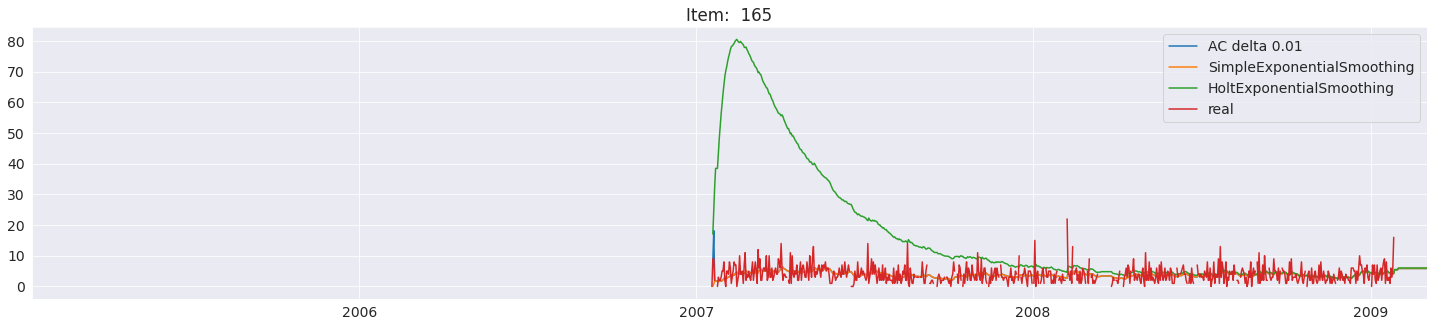

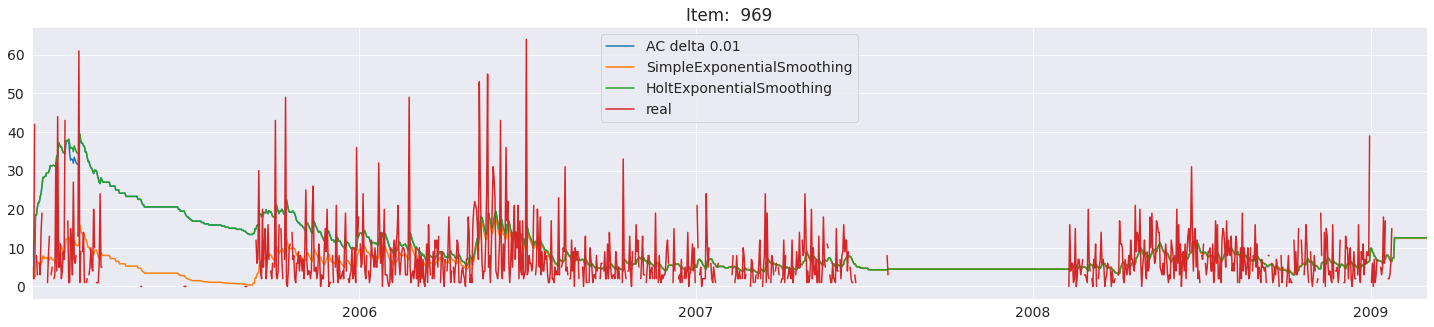

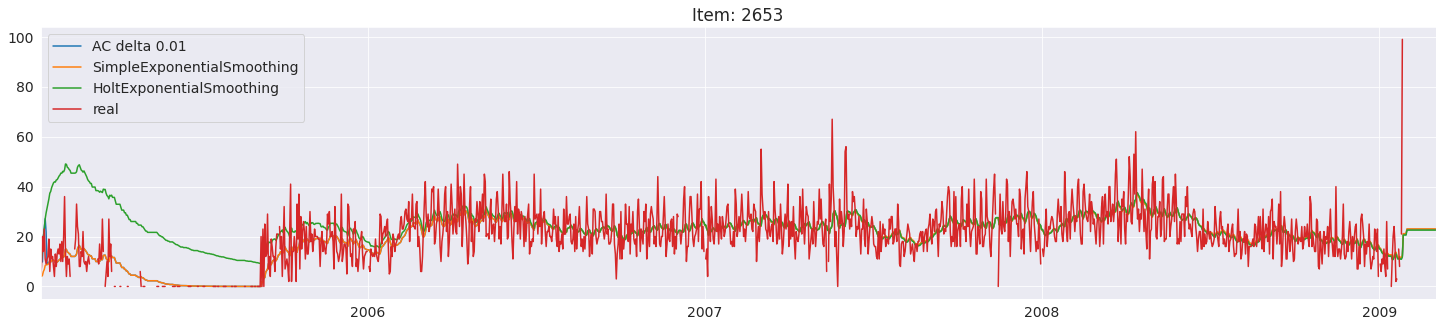

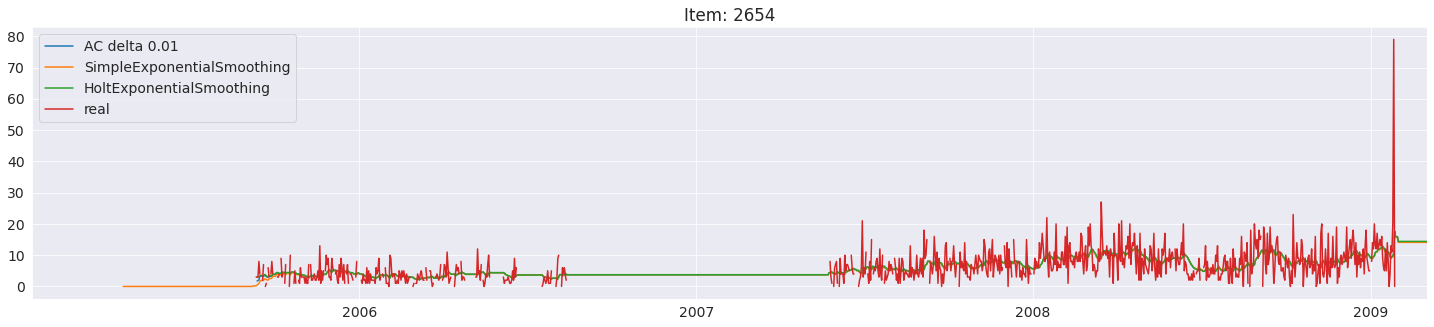

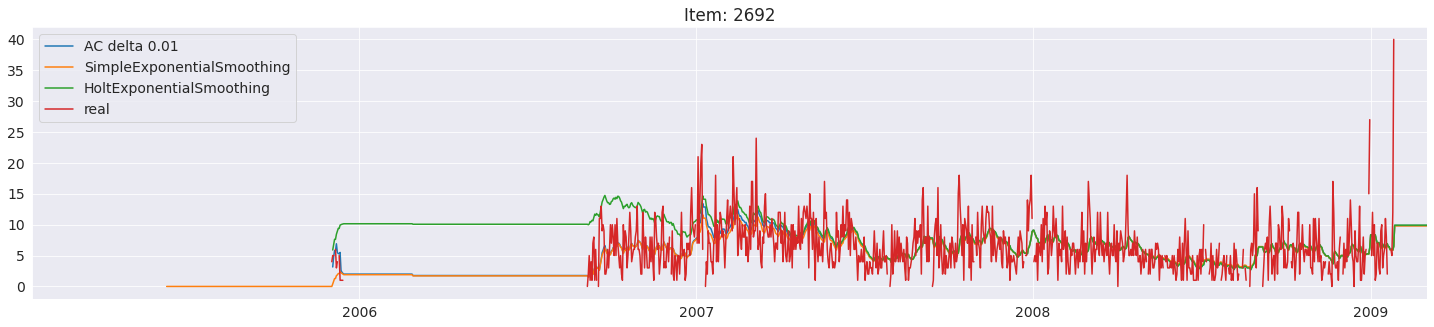

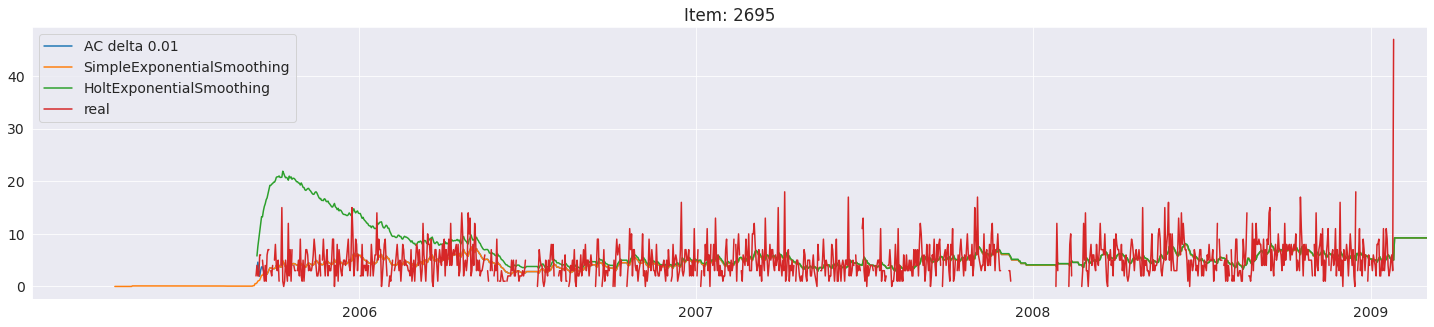

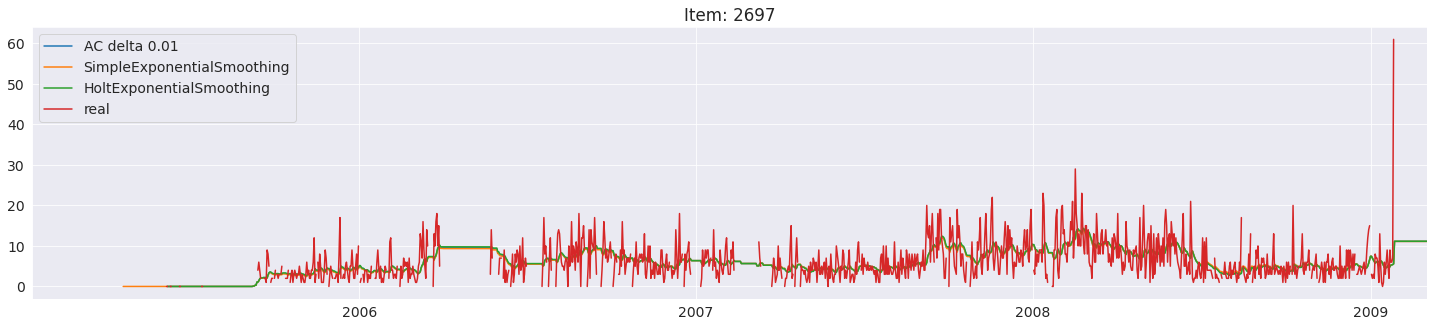

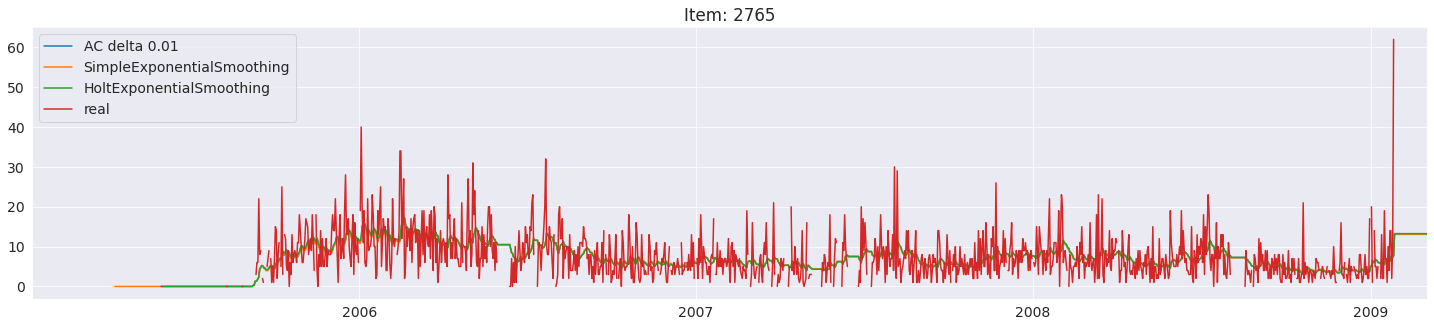

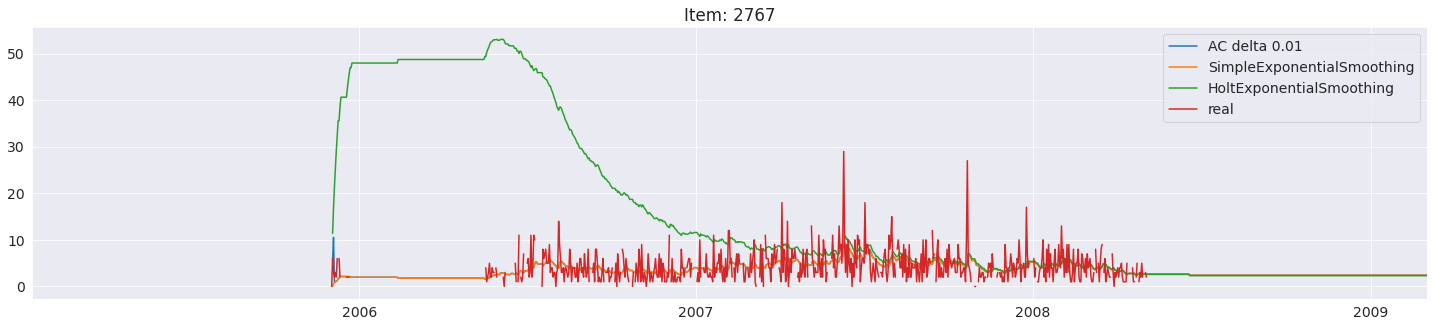

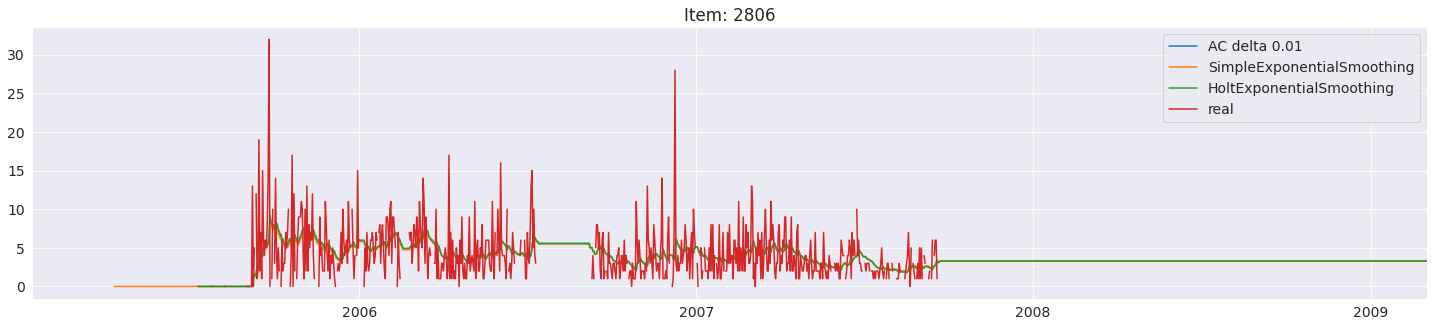

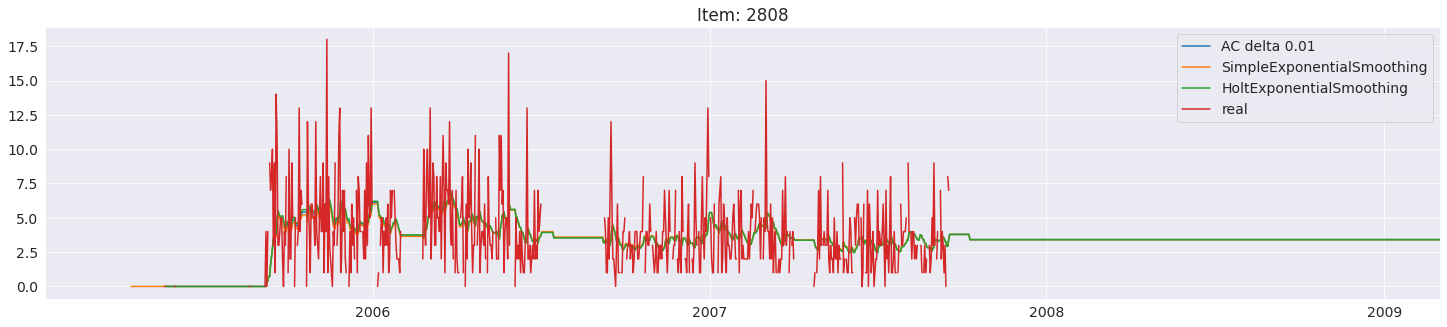

In [ ]:
# draw forecast of Adaprive Selection
alg_name = 'AC delta %.2f' % (delta)
for col in ts.columns:
    forecast = FRC_TS[alg_name][[col]].copy(deep=True)
    forecast.rename(columns={col:alg_name}, inplace=True)
    for i in range(len(base_algs)):
      forecast[base_algs[i]['base_alg']] = BA_FRC_TS[col][i]
      # print(BA_FRC_TS[col][i])
      # pd.DataFrame(BA_FRC_TS[col][i]).plot(color='blue', label=base_algs[0]['base_alg'], alpha = 1)
  #  forecast[col].plot(color='red', label=alg_name, alpha = 1)
    forecast['real'] = ts[col]
    forecast.plot()
    plt.title(col)
    plt.legend()
    plt.show()

# Aggregating Algorithm
**Questions**
* How to make forecast of a composition more resistent to forecasts of based algorithms?

## Idea: composition should be based on loss values rather than forecast values: 

* Example: binary squared game $\Omega = \{0, 1\}$, $\Gamma=[0, 1], \lambda = (\omega-\gamma)^2$
* Task 1
  - base algorithm 1 builds constant forecast $0$;
  - how can we build forecast of composition ${AA}$ such that $$\mathsf{Loss}_{AA}\leq \frac{1}{2}\mathsf{Loss}_1?$$
  - $\color{red}{Answer: ???}$
* Task 2
 - base algorithm 1 gets an average penalty $\frac{1}{2}$
 - how can we build forecast of composition ${AA}$ such that $$\mathsf{Loss}_{AA}\leq \frac{1}{2}\mathsf{Loss}_1?$$
 - $\color{red}{Answer}$: we build a constant forecast $\frac{1}{2}$
* Conclusion: it is more important to look at losses rather than at the forecast itself

## Composition based on Aggregating Algorithm

* Here are $N$ base algorithms.
* Parameters: $\beta\in(0,1)$, initial weights of base algorithms: $p_{j,0}=1/N$
* For $t=0,\dots,T-1$
 - obtain prediction of experts $\hat{y}_{j,t+1}, \forall{j}=\overline{1,N}$;
 - calculate mixability function:
 $$g(y) = \log_{\color{red}{\beta}}\Bigl( \sum_{j=1}^N{p_{j,t}\cdot\color{red}{\beta}^{\lambda(y, \hat{y}_{j,t+1})}}\Bigr)
$$ 
 - Calculate forecast of the composition $AA_1$:
 $$\hat{y}_{\color{red}{AA_1}, t+1}=\frac{Y_2\sqrt{g(Y_1)}+Y_1\sqrt{g(Y_2)}}{\sqrt{g(Y_1)}+ \sqrt{g(Y_2)}};$$
 - (another option is composition $AA_2$):
 $$\hat{y}_{\color{red}{AA_2}, t+1}=\frac{g(Y_1)-g(Y_2)}{2(Y_2-Y_1)}+\frac{Y_1+Y_2}{2};$$
 - obtain actual value $y_{t+1}$; 
  - update weights of base algorithms  $$p_{j, t+1}=\beta^{\lambda(y_{t+1},\hat{y}_{j,t+1})}\cdot{p_{j,t}}$$.
                    
**Questions**
* What is main advantage of Aggregating Algorithm?
  

In [ ]:
def norm_log_weights(weights):
    #"norm weigths ore whatever comes in (beta)"
    minima = np.min(weights)
    maxim = np.max(weights)
    weights = weights - minima - (maxim - minima) / 2
    #if (np.max(weights) - np.min(weights) > 10):
    #    weights -= np.max(weights) - 5
    weights = np.maximum(weights, -500)
    weights = np.minimum(weights, 500)
    return weights
    

def calc_g(Y, predicted, function, weights_log, beta):
    g = 0
    weights = get_weights(weights_log)
    #weights = sigmoid(weights)
    g = np.sum(weights * np.power(beta, function(Y, predicted)))
    g = np.log(g) / np.log(beta)
    if np.isinf(g):
        print("TTTT")
    return g

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def upper_bound(current_loss, Y1, Y2, M = 2):
    K = 2
    alpha = math.sqrt((Y2 - Y1) * K * np.log(M) / (4 * np.min(current_loss)))
    L = (1 + alpha) * np.min(current_loss) + (1 + alpha) / alpha * (Y2 - Y1) * K / 4 * np.log(M)
    return L

def get_weights(log_weights):
    res = np.exp(log_weights)
    res /= np.sum(res)
    return res


In [ ]:
#from utils import norm_log_weights, calc_g, sigmoid, upper_bound

ensemble_losses = []
bound = []


def aa_composition(x, h, params, function = MAE, debug = False):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)
    # base algs Forecasts
    base_algs = params['base_algs']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    # internal params of composition
    beta = params['beta']
    weights = params['weights']
    weights_log = np.log(weights)
    if beta>1:
        w.warn('Beta can not be more than 1')
        #alpha = 1
        return FORECAST
    if beta<0:
        w.warn('Beta can not be less than 0')
        #alpha = 0
        return FORECAST
    loss = np.zeros((len(base_algs)))
    #probably insert here pre-calculation of Y1 - averall min and Y2 - averall max
    #or insert it normal-mode - online calculation before g() calsualtion
    #Y1 = np.min(x)
    #Y2 = np.max(x)
    y = np.NaN
    cum_ensemble_loss = 0
    ensemble_losses = []
    bound = []
    for t in range(0, T):
        if not math.isnan(x[t]):
            predicted = FORECAST_BA.transpose()[t + 1]
            current_loss = function(x[t], predicted)
            loss += current_loss
            weights_log = np.log(beta) * loss
            weights_log = norm_log_weights(weights_log)
            weights = get_weights(weights_log)
            Y1 = np.min(x[:t + 1])
            Y2 = np.max(x[:t + 1])
            #beta = np.exp(-2. / ((Y2 - Y1) ** 2))
            gY1 = calc_g(Y1, predicted, function, weights_log, beta)
            gY2 = calc_g(Y2, predicted, function, weights_log, beta)
            ub = upper_bound(loss, Y1, Y2)
            if (function == MAE):
                #MAE case
                y = (Y2 * gY1 + Y1 * gY2) / (gY1 + gY2)
            else:
                y = (Y2 * np.sqrt(gY1) + Y1 * np.sqrt(gY2)) / (np.sqrt(gY1) + np.sqrt(gY2))
                #y = yAA = (gY1 - gY2) / 2 / (Y2 - Y1 + 0.0000000001) + (Y1 + Y2) / 2
            ensemble_loss = function(y, x[t])
            if (not math.isnan(ensemble_loss)):
                #print(cum_ensemble_loss, ' ', ensemble_loss)
                cum_ensemble_loss += ensemble_loss
            bound.append(ub)
            ensemble_losses.append(cum_ensemble_loss)
                
        FORECAST[t+h] = y
    return FORECAST, FORECAST_BA, ensemble_losses, bound

In [ ]:
# run (build forecast) Aggregating Algorithm

h =1 # forecast horizon
# define base algorithm
frc_ts = pd.DataFrame(index = ts.index.append(
    pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)

FRC_TS = dict()
BA_FRC_TS = dict()

beta = 0.9
bound_res = ensemble_losses_res = []
for cntr in ts.columns:
    frc_ts[cntr],BA_FRC_TS[cntr], ensemble_losses, bound = aa_composition(ts[cntr],h, 
                                  {'beta':beta, 'weights': np.array([0.5, 0.5]), 'base_algs':base_algs}, 
                                  function = MAE, debug = True)
    if (ensemble_losses != []):
        bound_res = bound
        ensemble_losses_res = ensemble_losses
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

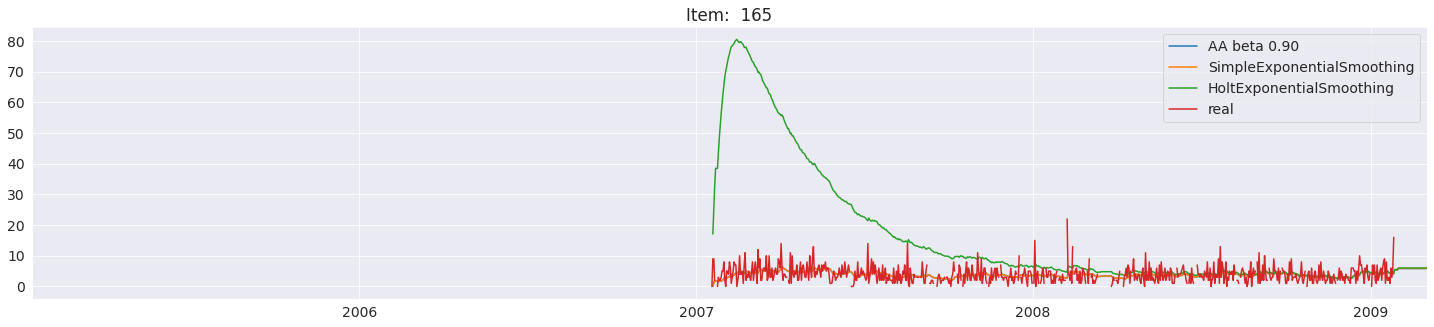

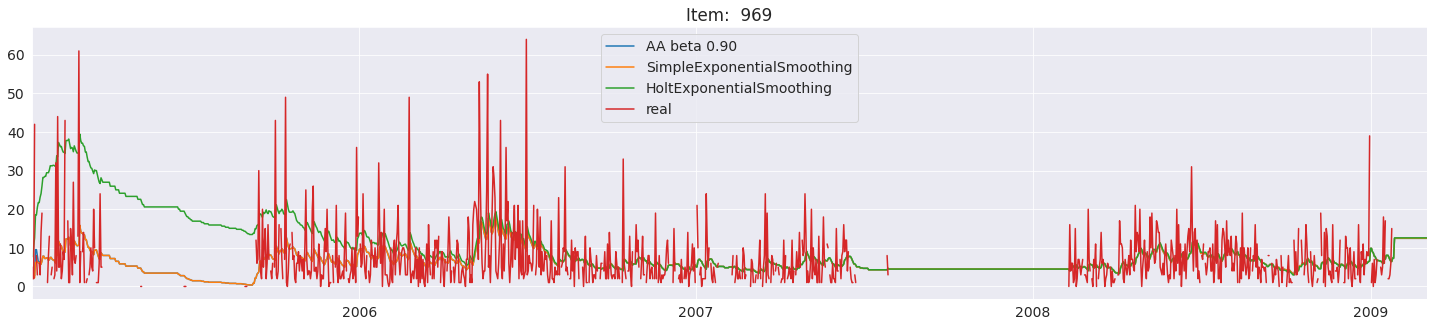

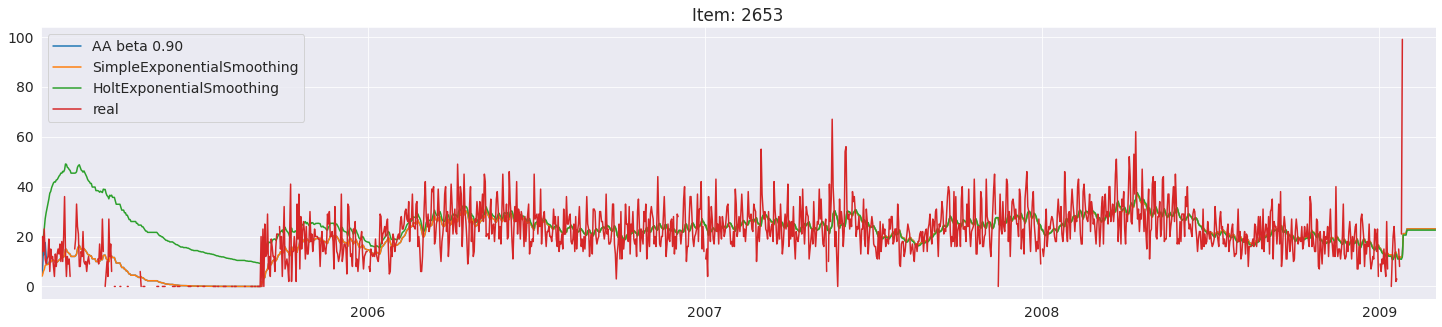

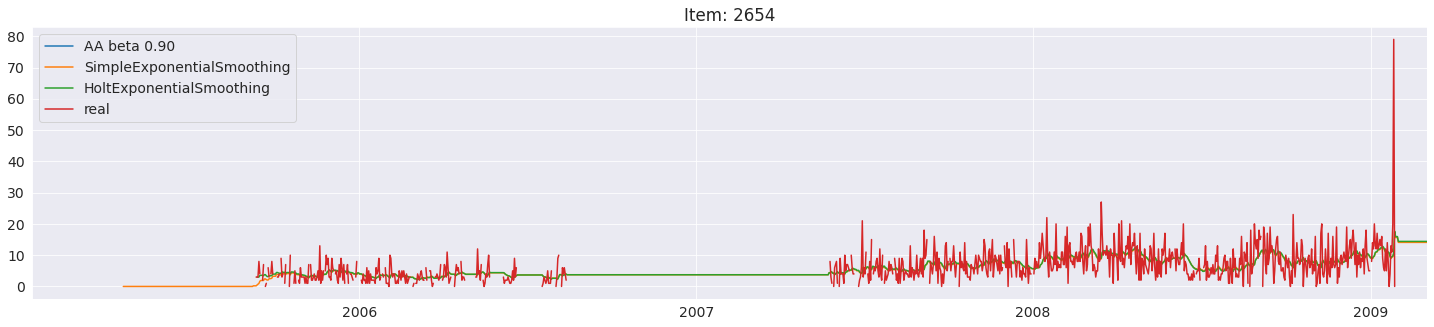

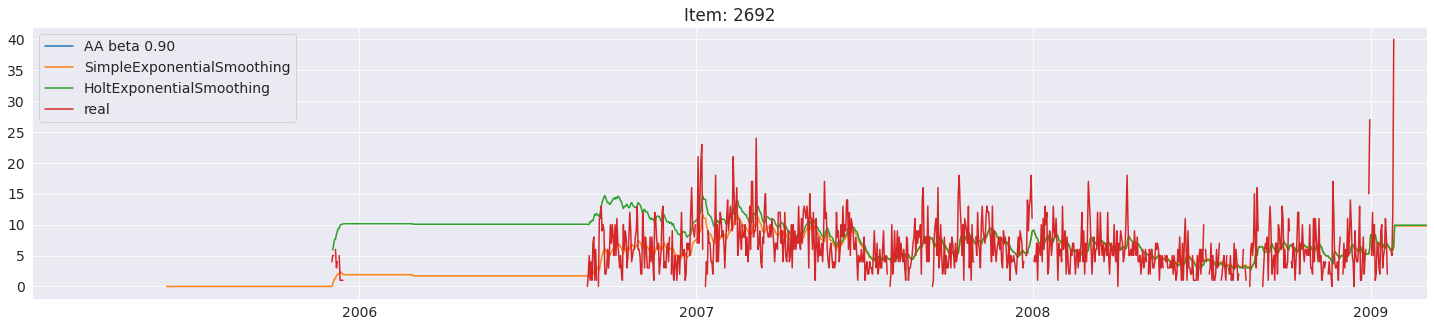

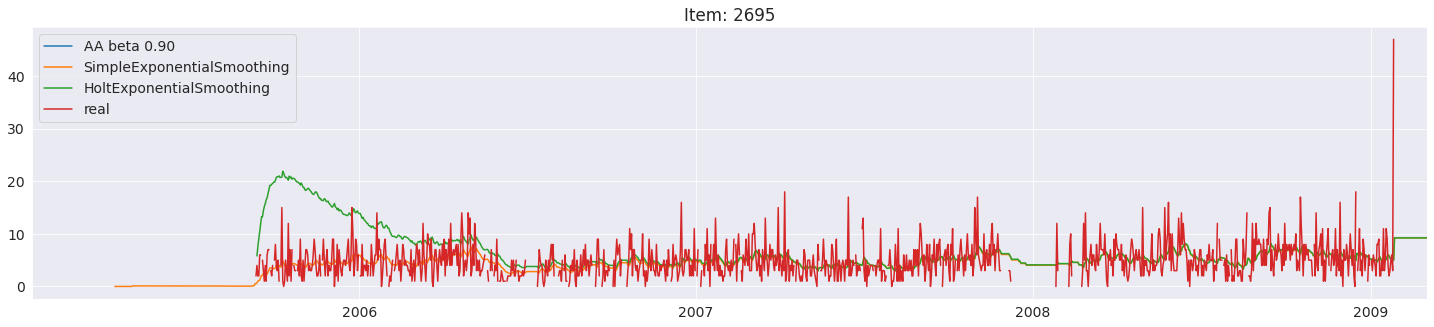

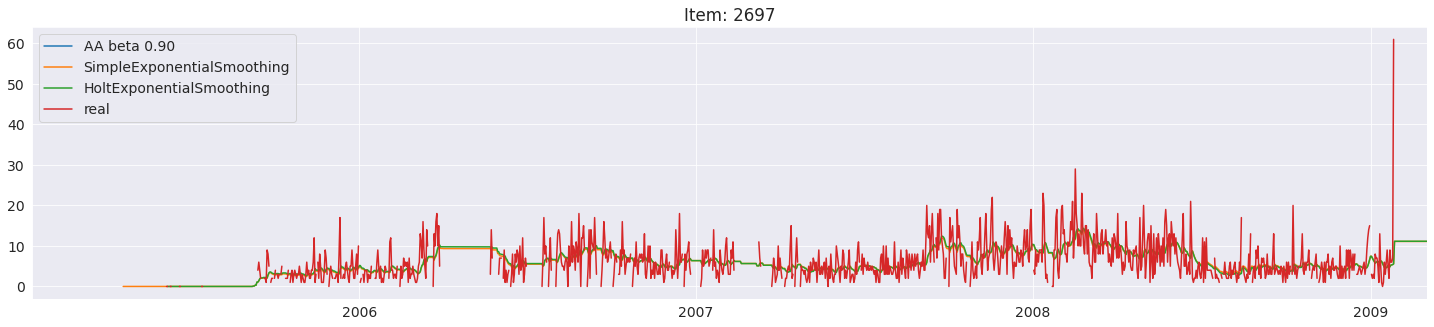

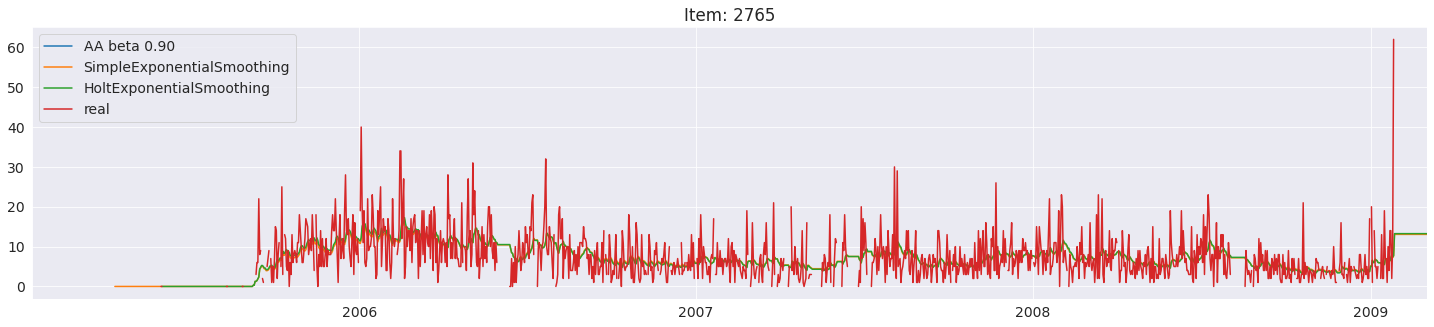

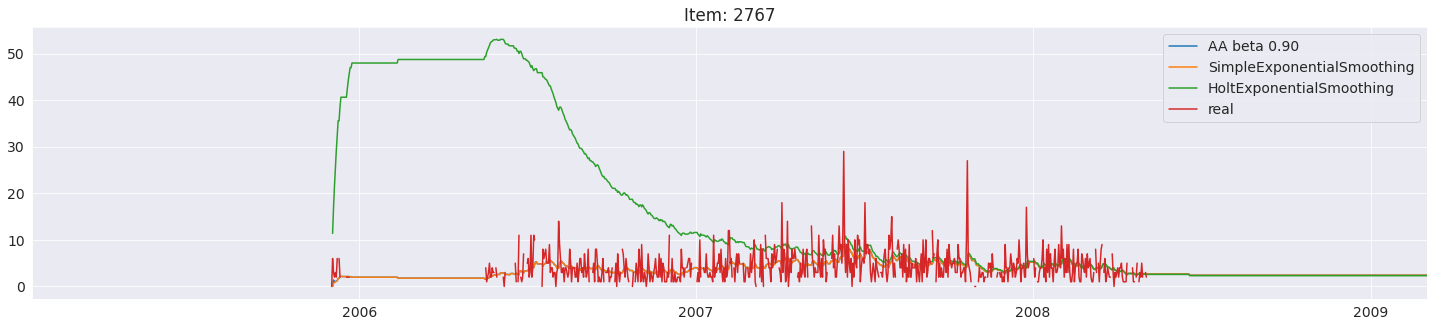

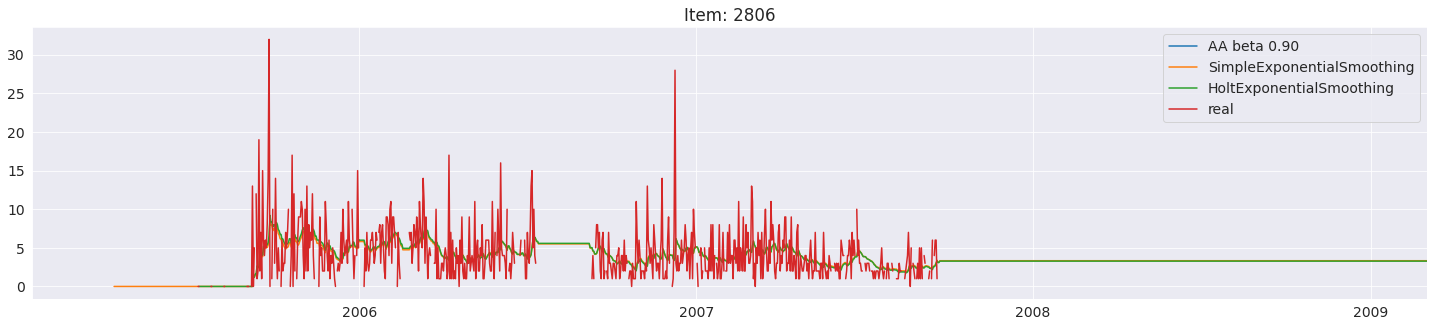

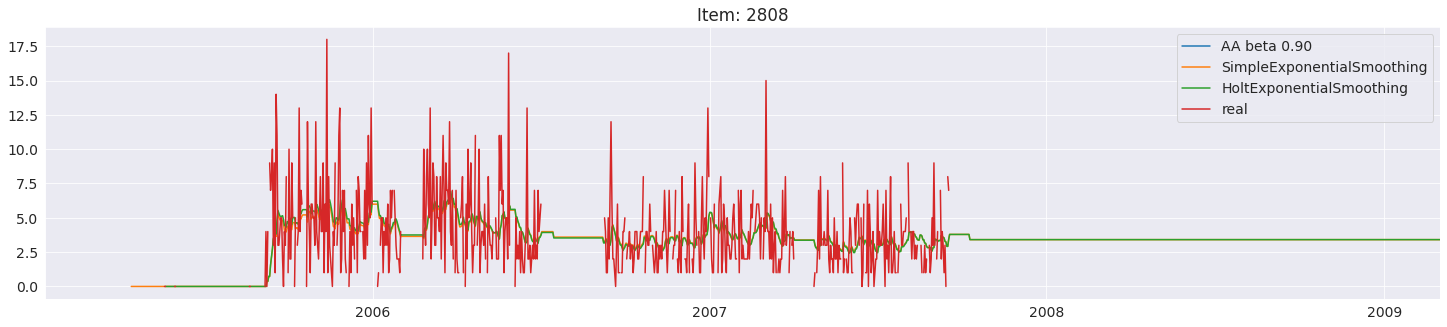

In [ ]:
# draw forecast of Adaprive Selection
alg_name = 'AA beta %.2f' % (beta)
for col in ts.columns:
    forecast = FRC_TS[alg_name][[col]].copy(deep=True)
    forecast.rename(columns={col:alg_name}, inplace=True)
    for i in range(len(base_algs)):
      forecast[base_algs[i]['base_alg']] = BA_FRC_TS[col][i]
      # print(BA_FRC_TS[col][i])
      # pd.DataFrame(BA_FRC_TS[col][i]).plot(color='blue', label=base_algs[0]['base_alg'], alpha = 1)
  #  forecast[col].plot(color='red', label=alg_name, alpha = 1)
    forecast['real'] = ts[col]
    forecast.plot()
    plt.title(col)
    plt.legend()
    plt.show()

**Materials**
* Hierarchical Forecasting in python: https://towardsdatascience.com/introduction-to-hierarchical-time-series-forecasting-part-ii-e73dfd3de86b

* Aggregating Algorithm http://onlineprediction.net/index.html?n=Main.StrongAggregatingAlgorithm